In [86]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd
import numpy as np


def categorize_target(change):
    if change < -0.05:
        return '-5pct'
    elif -0.05 <= change < -0.02:
        return '-2pct'
    elif -0.02 <= change <= 0.02:
        return '0pct'
    elif 0.02 < change <= 0.05:
        return '+2pct'
    elif change > 0.05:
        return '+5pct'
    else:
        return None


def prepare_xgboost_data():
    df = pd.read_csv(
        'data/data-hour-clean.csv',
        parse_dates=['ts',],
        index_col='ts',
    ).copy()

    # Some indicators
    df['returns'] = df['close'].pct_change()
    df['high_low_ratio'] = df['high'] / df['low']
    df['close_open_ratio'] = df['close'] / df['open']
    df['true_range'] = np.maximum(
        df['high'] - df['low'],
        np.maximum(
            abs(df['high'] - df['close'].shift(1)),
            abs(df['low'] - df['close'].shift(1))
        )
    )

    # Historical values
    for period in [1, 2, 3, 6, 12, 24, 48, 126]:
        if period > 2:
            df[f'returns_mean_{period}h'] = df['returns'].rolling(period).mean()
            df[f'returns_std_{period}h'] = df['returns'].rolling(period).std()
        
            # Price levels
            df[f'close_sma_{period}h'] = df['close'].rolling(period).mean()
            df[f'close_ema_{period}h'] = df['close'].ewm(span=period).mean()
        
            # Volatility
            df[f'true_range_mean_{period}h'] = df['true_range'].rolling(period).mean()
            df[f'high_low_ratio_mean_{period}h'] = df['high_low_ratio'].rolling(period).mean()
        
            # Volume
            df[f'volume_mean_{period}h'] = df['volume'].rolling(period).mean()
            df[f'volume_std_{period}h'] = df['volume'].rolling(period).std()
                
            # Intraday volatility features
            df[f'logret_intra_vol_mean_{period}h'] = df['logret_intra_vol'].rolling(period).mean()
            df[f'logret_intra_skew_mean_{period}h'] = df['logret_intra_skew'].rolling(period).mean()
            df[f'logret_intra_kurt_mean_{period}h'] = df['logret_intra_kurt'].rolling(period).mean()

        if period > 3:
            df[f'returns_vol_{period}h'] = df['returns'].rolling(period).std()
            df[f'returns_skew_{period}h'] = df['returns'].rolling(period).skew()
            df[f'returns_kurt_{period}h'] = df['returns'].rolling(period).kurt()
    
    df = df.dropna()
    return df


def prepare_ts_data():
    df = pd.read_csv(
        'data/data-hour-clean.csv',
        parse_dates=['ts',],
        index_col='ts',
    ).sort_index()

    # Some indicators
    df['returns'] = df['close'].pct_change()
    df['high_low_ratio'] = df['high'] / df['low']
    df['close_open_ratio'] = df['close'] / df['open']
    df['true_range'] = np.maximum(
        df['high'] - df['low'],
        np.maximum(
            abs(df['high'] - df['close'].shift(1)),
            abs(df['low'] - df['close'].shift(1))
        )
    )
    df = df.dropna()
    return df


def plot_cm(pred, gt):
    print("Accuracy", accuracy_score(gt, pred))

    classes = ['+5pct', '+2pct', '0pct', '-2pct', '-5pct']
    cm = confusion_matrix(gt, pred, labels=classes)
    cm = (cm / len(gt)) * 100
    plt.figure(figsize=(6, 4))

    sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=classes, yticklabels=classes)
    
    # Labeling the plot
    plt.title("Confusion Matrix (normalized in %)")
    plt.xlabel("Predicted")
    plt.ylabel("GT")
    
    # Show the plot
    plt.show()

# 1. Baseline
- Prediction is the most frequest class - 0pct change.

In [221]:
df = prepare_xgboost_data()

le = LabelEncoder()

y = le.fit_transform(df['target'])

print('Accuracy (Val) ', np.mean(y[df['split'] == 'val'] == 4))
print('Accuracy (Test)', np.mean(y[df['split'] == 'test'] == 4))

Accuracy (Val)  0.9032258064516129
Accuracy (Test) 0.8069444444444445


# 2. XGBoost Classifier and Regressor
- Classifier - Perform classification directly
- Regressor - Perform first regression and then bin results into classes
- Random search over 100 hyper parameters on validation set


In [78]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
import random


class XGBoostClassifier:
    """ XGBoost model for multi-class classification. """

    def __init__(self, class_labels, **kwargs):
        self.class_labels = class_labels  # List of class labels
        self.model = None
        self.kwargs = kwargs

    def fit(self, X_train, y_train):
        data = xgb.DMatrix(X_train, label=y_train)
        params = {
            "objective": "multi:softmax",
            "num_class": len(self.class_labels),
            "eval_metric": "merror",
        } | self.kwargs
        num_boost_round = params.pop('num_boost_round')
        self.model = xgb.train(params, data, num_boost_round=num_boost_round)

    def predict(self, X_test):
        data = xgb.DMatrix(X_test)
        preds = self.model.predict(data)
        predicted_labels = [self.class_labels[int(pred)] for pred in preds]
        return predicted_labels


class XGBoostRegressor:
    """ XGBoost model for regression. """

    def __init__(self, transform_pred=None, **kwargs):
        self.transform_pred = transform_pred
        self.model = None
        self.kwargs = kwargs


    def fit(self, X_train, y_train):
        data = xgb.DMatrix(X_train, label=y_train)
        
        params = {
            "objective": "reg:squarederror",
            "eval_metric": "rmse",
        } | self.kwargs
        num_boost_round = params.pop('num_boost_round')
        self.model = xgb.train(params, data, num_boost_round=num_boost_round)

    def predict(self, X_test):
        data = xgb.DMatrix(X_test)
        preds = self.model.predict(data)
        if self.transform_pred is not None:
            preds = [self.transform_pred(pred) for pred in preds]
        return preds


def random_param_combination():
    param_grid = {
        'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.5, 0.7],
        'num_boost_round': [20, 50, 100, 200],
        'max_depth': [3, 5, 7, 9, 10],
        'min_child_weight': [1, 3, 5, 7],
        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.6, 0.7, 0.8, 1.0],
        'gamma': [0, 0.1, 0.2, 0.5, 1.0],
        'lambda': [0, 0.1, 1, 10],
        'alpha': [0, 0.1, 1, 10],
    }
    return {param: random.choice(values) for param, values in param_grid.items()}



In [230]:
df = prepare_xgboost_data()

le = LabelEncoder()
y = le.fit_transform(df['target'])
x = df.drop(columns=['split', 'target_ret', 'target'])

y_train = y[df['split'] == 'train']
y_reg_train = df[df['split'] == 'train']['target_ret'].values
x_train = x[df['split'] == 'train']

y_val = y[df['split'] == 'val']
y_val = df[df['split'] == 'val']['target_ret'].values
x_val = x[df['split'] == 'val']
gt_val = df[df['split'] == 'val']['target'].values

### Find Hyperparameters

In [233]:
random.seed(10)
results = []

for i in tqdm(range(100)):
    params = random_param_combination()
    
    model = XGBoostClassifier(class_labels=le.classes_, **params)
    model.fit(x_train, y_train)
    preds = model.predict(x_val)
    acc_cls = accuracy_score(gt_val, preds)

    model = XGBoostRegressor(**params)
    model.fit(x_train, y_reg_train)
    preds = model.predict(x_val)
    preds = pd.Series(preds).apply(categorize_target)
    acc_reg = accuracy_score(gt_val, preds)

    params['acc_cls'] = acc_cls
    params['acc_reg'] = acc_reg
    results.append(params)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [10:23<00:00,  6.23s/it]


In [265]:
df_xgboost = pd.DataFrame(results)
display(df_xgboost[['acc_cls', 'acc_reg']].max())
best_hp = df_xgboost.iloc[df_xgboost['acc_cls'].idxmax()]
df_xgboost.to_csv('results/xgboost_val.csv')

print('\n')
display(best_hp)

acc_cls    0.909946
acc_reg    0.903226
dtype: float64

learning_rate         0.300000
num_boost_round     200.000000
max_depth             5.000000
min_child_weight      5.000000
subsample             0.900000
colsample_bytree      0.800000
gamma                 1.000000
lambda               10.000000
alpha                 1.000000
acc_cls               0.909946
acc_reg               0.903226
Name: 23, dtype: float64

### Final Prediction

Use hyperparameters:

- 'learning_rate': 0.3,
- 'num_boost_round': 200.0,
- 'max_depth': 5.0,
- 'min_child_weight': 5.0,
- 'subsample': 0.9,
- 'colsample_bytree': 0.8,
- 'gamma': 1.0,
- 'lambda': 10.0,
- 'alpha': 1.0
 

In [254]:
df = prepare_xgboost_data()

le = LabelEncoder()
y = le.fit_transform(df['target'])
x = df.drop(columns=['split', 'target_ret', 'target'])

y_train = y[(df['split'] == 'train') | (df['split'] == 'val')]
x_train = x[(df['split'] == 'train') | (df['split'] == 'val')]

y_test = y[df['split'] == 'test']
x_test = x[df['split'] == 'test']
gt_test = df[df['split'] == 'test']['target'].values

In [257]:
params = {
'learning_rate': 0.3,
'num_boost_round': 200,
'max_depth': 5,
'min_child_weight': 5.0,
'subsample': 0.9,
'colsample_bytree': 0.8,
'gamma': 1.0,
'lambda': 10.0,
'alpha': 1.0
}

model = XGBoostClassifier(class_labels=le.classes_, **params)
model.fit(x_train, y_train)
preds = model.predict(x_test)
acc_cls = accuracy_score(gt_test, preds)


### Evaluation
- Does not beat simple baseline.

Accuracy 0.7597222222222222


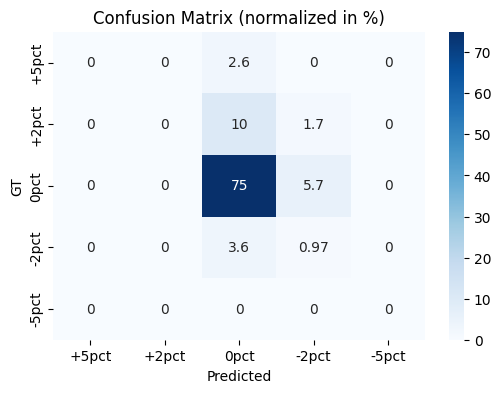

In [315]:
plot_cm(preds, gt_test)

# Temporal Fusion Transformer
- Implementation is from pytorch_forecasting library - https://pytorch-forecasting.readthedocs.io/en/stable/index.html
- Hyperparameters are from the pytorch_forecasting README page, except context length and prediction lenght.

In [7]:
import torch
import lightning.pytorch as pl
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.tuner import Tuner
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, QuantileLoss


class TFTModel:
    def __init__(
        self,
        batch_size=128,
    ):
        self.batch_size = batch_size
        self.model = None

    def fit(self, data):
        # Create dataset

        self.dataset_train = TimeSeriesDataSet(
            data.query("split == 'train'"),
            time_idx="time_idx",
            target="target_ret",
            group_ids=["series_id"],
            max_encoder_length=168, # One week
            max_prediction_length=10, # For stability
            time_varying_known_reals=[
                "high", "low", "close", "volume", "logret_intra_vol", "logret_intra_skew", 
                "logret_intra_kurt", "returns", "high_low_ratio", "close_open_ratio", "true_range",
            ],
            time_varying_unknown_reals=["target_ret"],
        )

        self.dataset_val = TimeSeriesDataSet.from_dataset(
            self.dataset_train,
            data.query("split == 'val'"),
            stop_randomization=True
        )


        # Create dataloaders
        loader_train = self.dataset_train.to_dataloader(
            train=True,
            batch_size=self.batch_size,
            num_workers=2
        )
        loader_val = self.dataset_val.to_dataloader(
            train=False,
            batch_size=self.batch_size,
            num_workers=2
        )

        # Define Trainer
        trainer = pl.Trainer(
            max_epochs=100,
            accelerator="auto",
            gradient_clip_val=0.1,
            limit_train_batches=30,
            callbacks=[
                EarlyStopping(
                    monitor="val_loss",
                    min_delta=1e-4,
                    patience=3,
                    verbose=True,
                    mode="min"
                ),
                LearningRateMonitor()
            ],
            logger=TensorBoardLogger("lightning_logs")
        )
        
        # Initialize the model
        self.model = TemporalFusionTransformer.from_dataset(
            self.dataset_train,
            hidden_size=32,
            attention_head_size=1,
            dropout=0.1,
            hidden_continuous_size=16,
            loss=QuantileLoss(),
            log_interval=2,
            learning_rate=0.03,
            reduce_on_plateau_patience=4
        )
        print(f"Number of parameters in network: {self.model.size()/1e3:.1f}k")

        # Find optimal learning rate
        res = Tuner(trainer).lr_find(
            self.model,
            train_dataloaders=loader_train,
            val_dataloaders=loader_val,
            early_stop_threshold=1000.0,
            max_lr=0.3,
        )

        # Fit the model
        trainer.fit(
            self.model,
            train_dataloaders=loader_train,
            val_dataloaders=loader_val,
        )
    

    def predict(self, data):
        dataset = TimeSeriesDataSet.from_dataset(
            self.dataset_train,
            data,
            stop_randomization=True
        )
        loader = dataset.to_dataloader(train=False, batch_size=self.batch_size)        
        preds = self.model.predict(loader, return_x=True)
        return preds

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/vojta/projects/ts-forecast/venv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/vojta/projects/ts-forecast/venv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
/home/vojta/projects/ts-forecast/venv/lib/python3.10/site-packages/pytorch_forecasting/models/temporal_fusion_transformer/__init__.py:171: UserWarning: In pytorch-forecasting models, on versions 1.1.X, the default optimizer defaults to 'adam', if pytorch_optimizer is not installed, otherwi

Number of parameters in network: 102.2k


/home/vojta/projects/ts-forecast/venv/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/home/vojta/projects/ts-forecast/venv/lib/python3.10/site-packages/pytorch_forecasting/models/base_model.py:1089: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()
`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0012146256641550406
Restoring states from the checkpoint path at /home/vojta/projects/ts-forecast/.lr_find_c712e9fa-956f-4ef5-8667-7f3b43ec963e.ckpt
Restored all states from the checkpoint at /home/vojta/projects/ts-forecast/.lr_find_c712e9fa-956f-4ef5-8667-7f3b43ec963e.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
-----------------------------------------------------------------

Sanity Checking: |                                                                                            …

/home/vojta/projects/ts-forecast/venv/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                                   …

Validation: |                                                                                                 …

Metric val_loss improved. New best score: 0.005


Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.005


Validation: |                                                                                                 …

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.004


Validation: |                                                                                                 …

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.004


Validation: |                                                                                                 …

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.004


Validation: |                                                                                                 …

Validation: |                                                                                                 …

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.004


Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.004


Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Monitored metric val_loss did not improve in the last 3 records. Best score: 0.004. Signaling Trainer to stop.


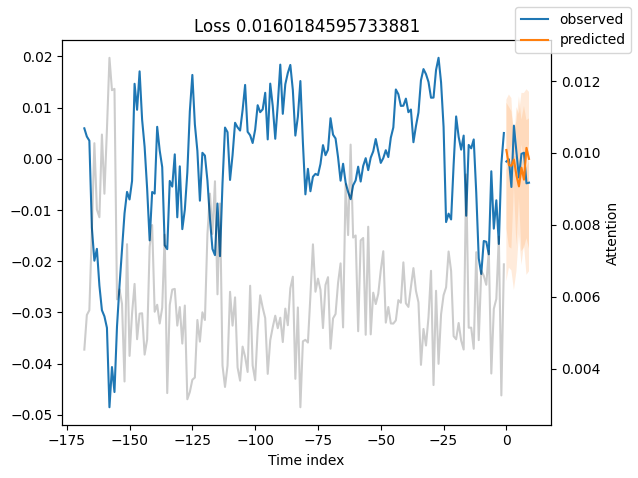

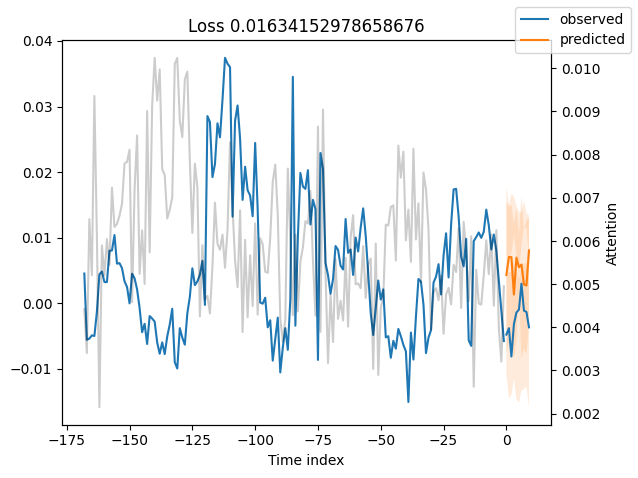

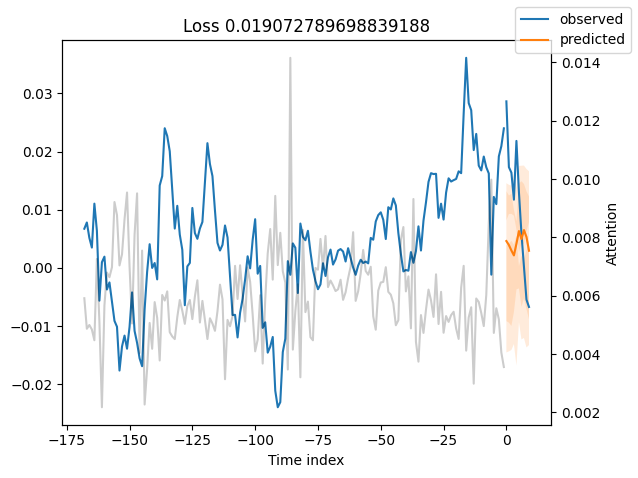

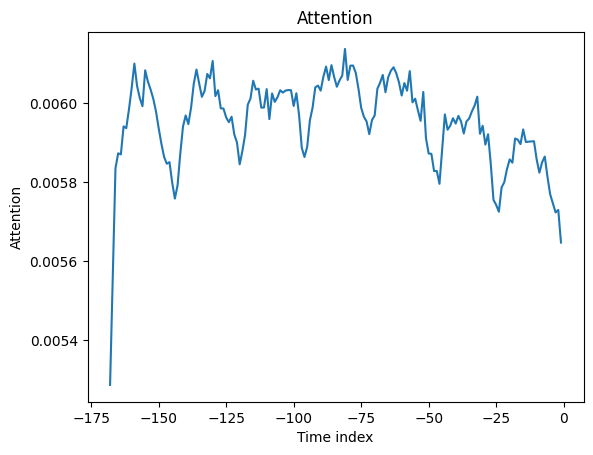

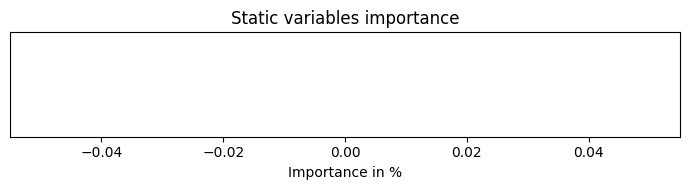

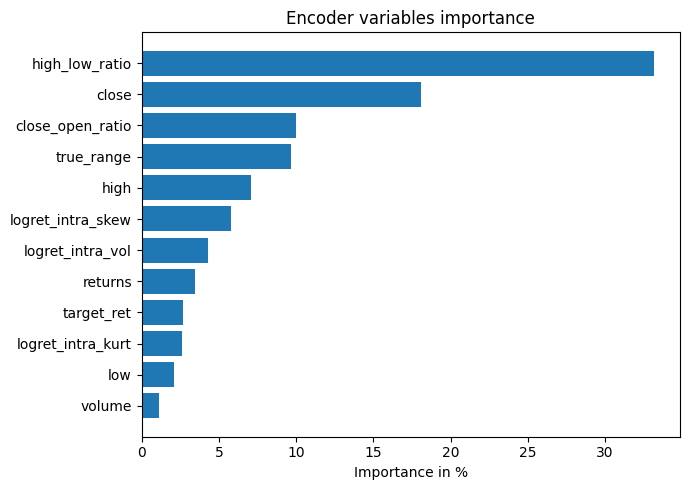

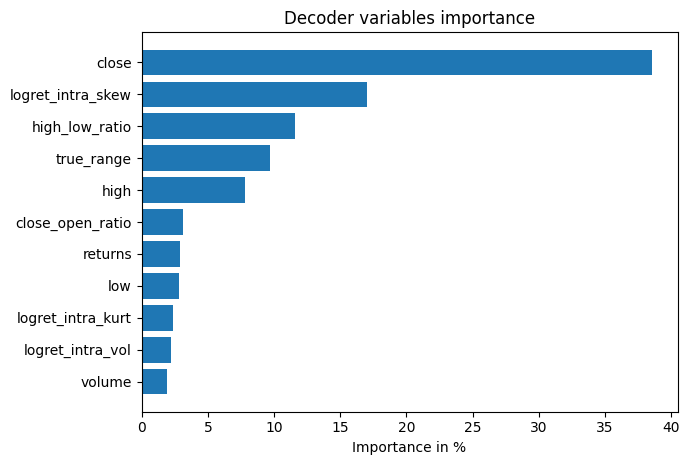

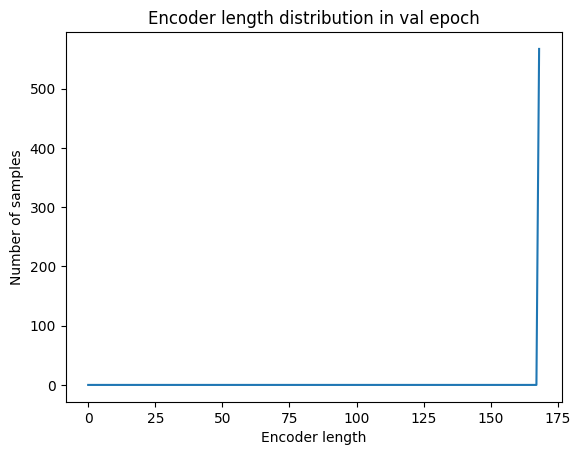

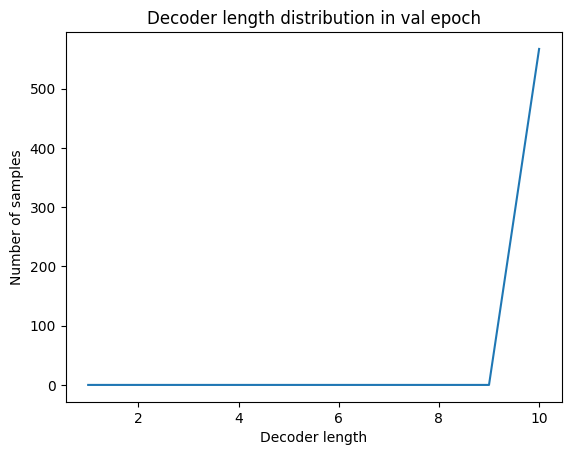

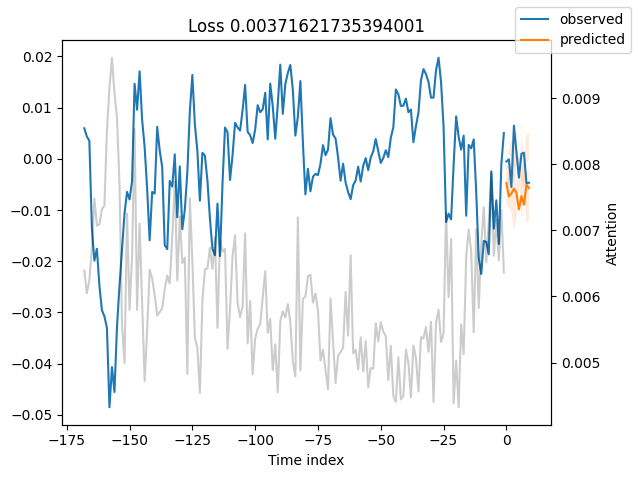

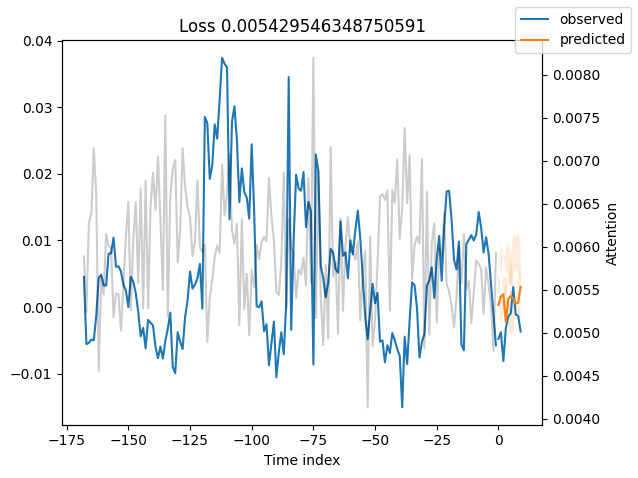

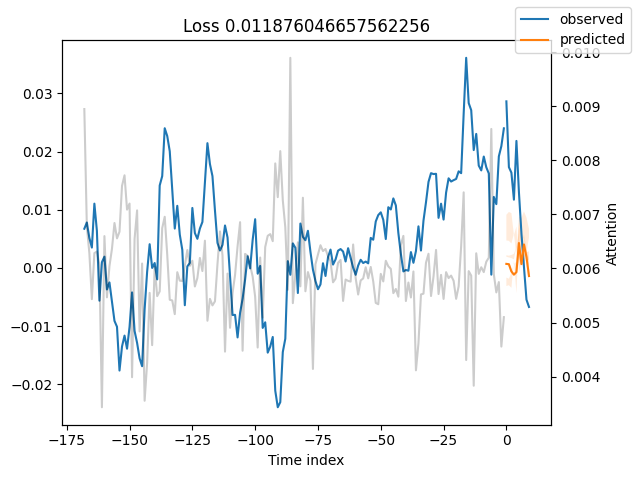

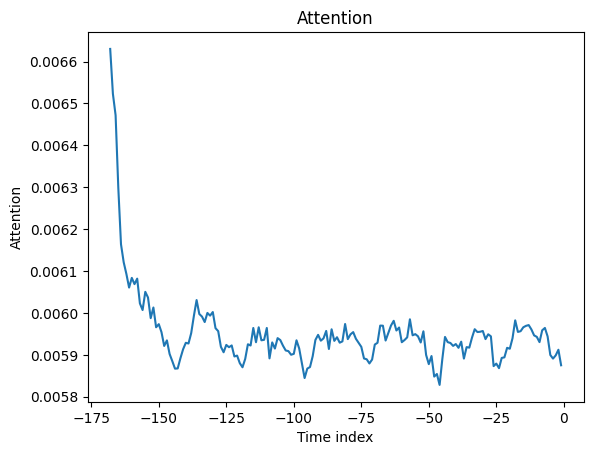

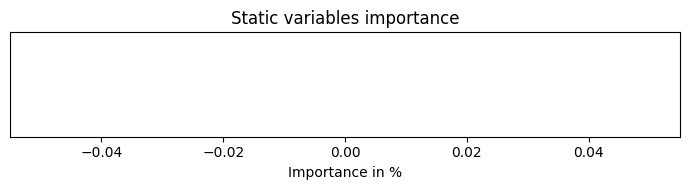

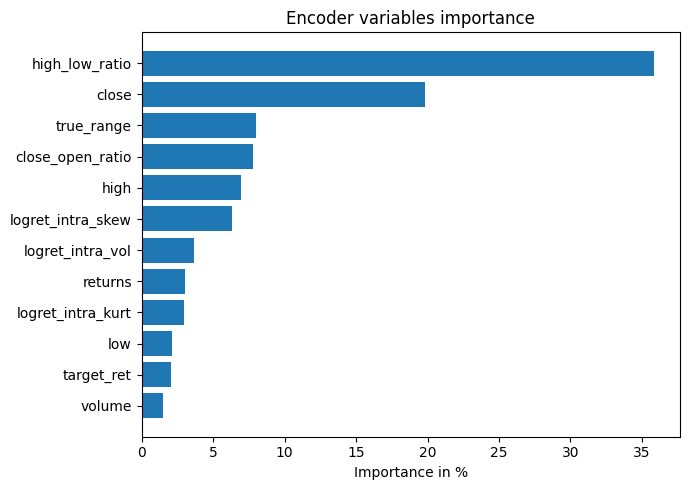

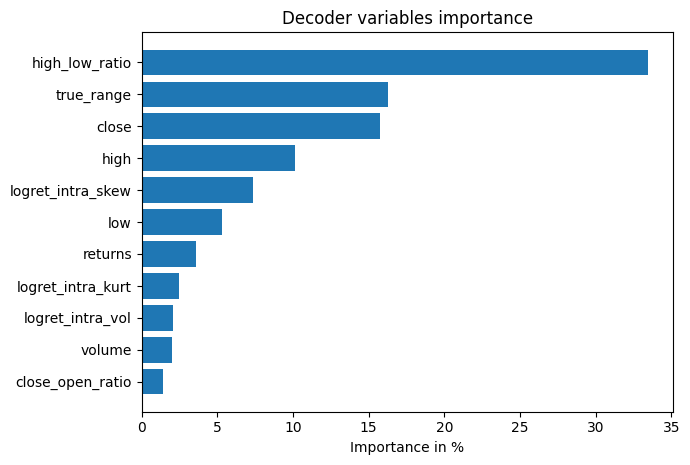

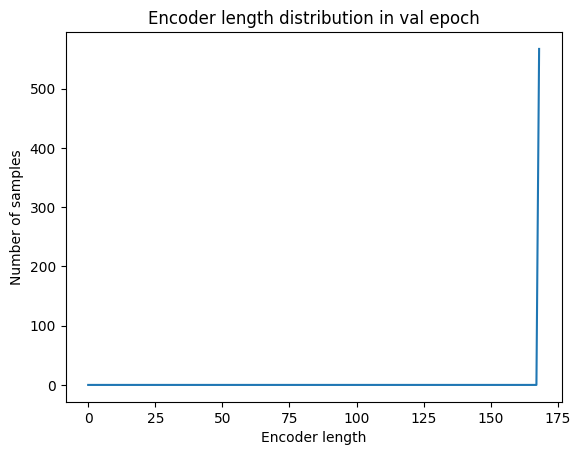

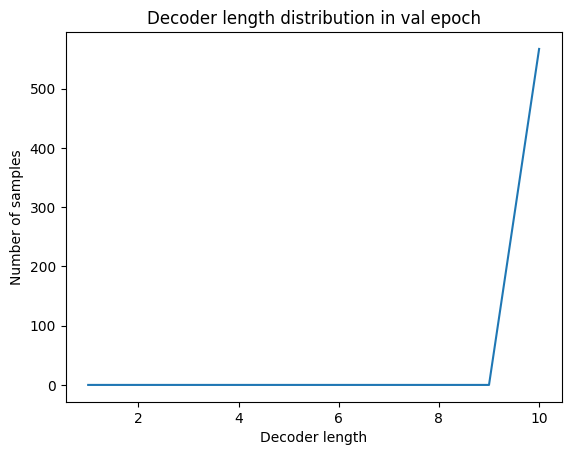

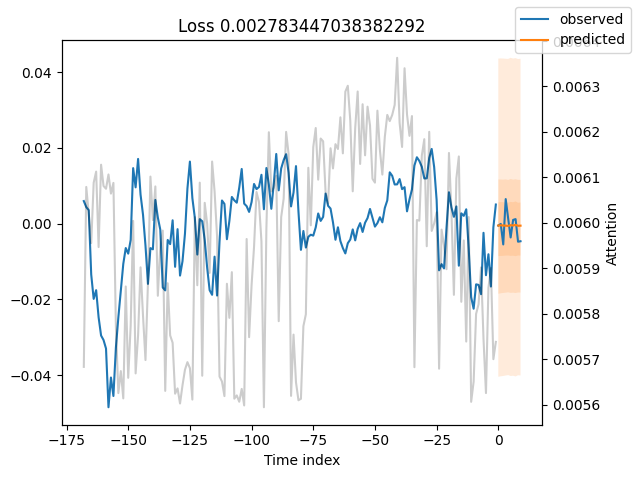

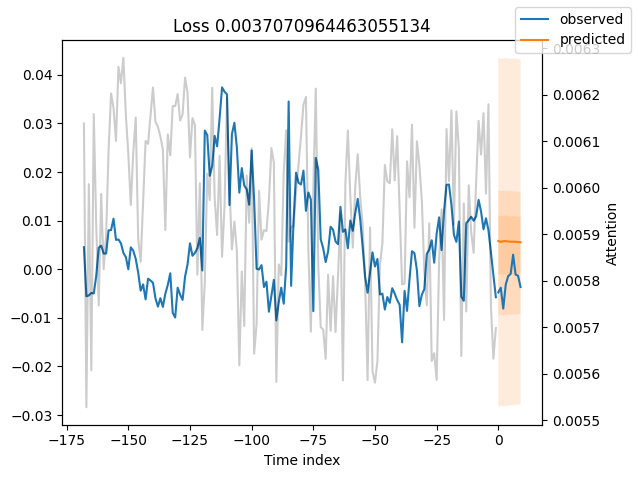

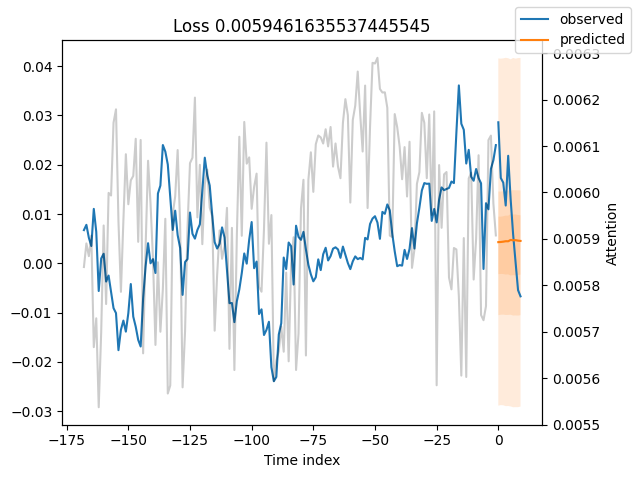

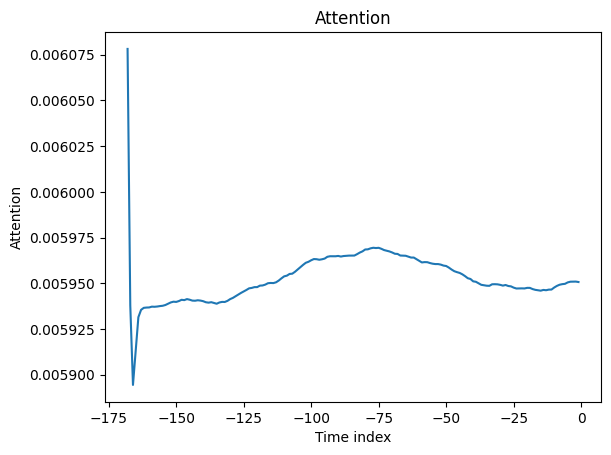

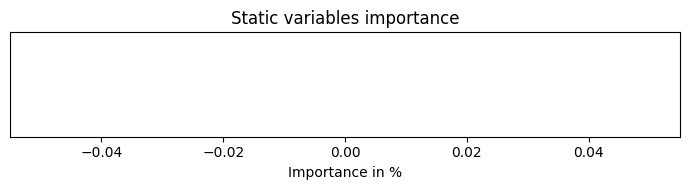

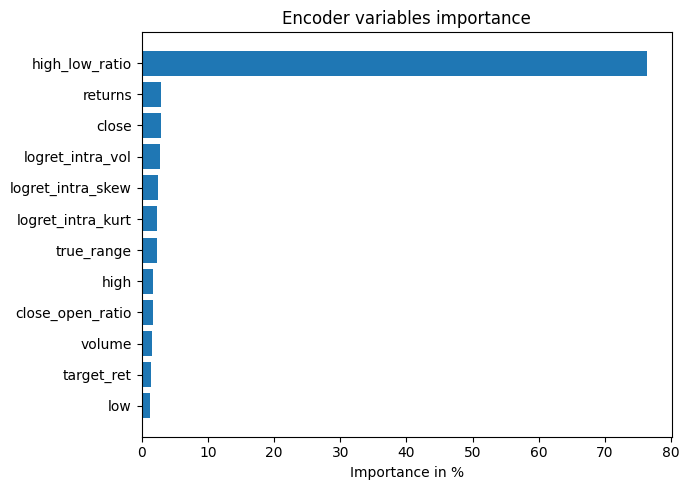

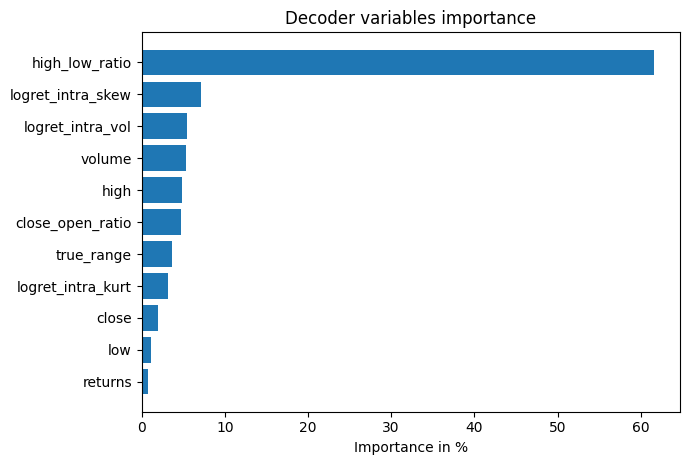

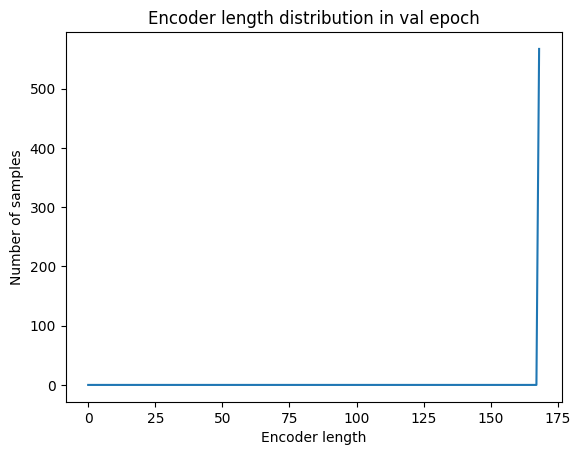

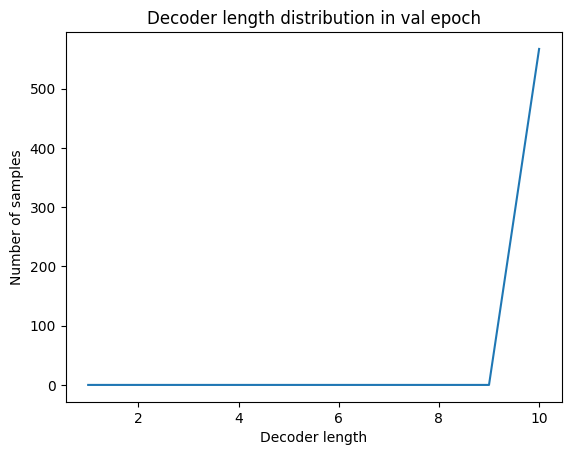

In [8]:
data = prepare_ts_data()
data = data.reset_index()
data["time_idx"] = (data["ts"] - data["ts"].min()).dt.total_seconds().astype(int) // 3600 # This is from tutorial
data["series_id"] = 0

model = TFTModel()
model.fit(data)

preds = model.predict(data) # Predict for all and postprocess later.

### Evaluation

- The TFT model shows promising performance, significantly outperforming the baseline (accuracy: 80% → 88%).
- On the validation set, the outperformance is smaller, but still significant (accuracy: 90% → 94%).
- Most errors are cases where the model predicted 0% change, but the actual change was +2%.

### Conclusion

- In my opinion, the results seem too good to be true, and I did not expect such performance solely from market data without any auxiliary data.
- I’m not familiar enough with the library and the underlying literature to be entirely confident in the results, and further inspection is needed.

Test results
Accuracy 0.8888888888888888


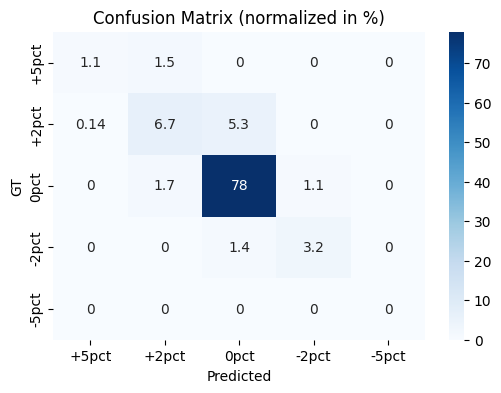

In [85]:
test_time_idx = data.query("split == 'test'")['time_idx'].values

i = 0 # Predict target in next row
pred_value = preds.output[:, i].cpu().numpy()
pred_idx = preds.x['decoder_time_idx'][:, i].cpu().numpy()


data['pred'] = 0.0
data.loc[pred_idx, 'pred'] = pred_value

df_test = data.query("split == 'test'").copy()
df_test['pred_cat'] = df_test['pred'].apply(categorize_target)
df_test = df_test[['ts', 'target', 'target_ret', 'pred', 'pred_cat']]
df_test.to_csv('results/tft_test.csv')

print('Test results')
plot_cm(df_test['pred_cat'], df_test['target'])

In [82]:
pred_value

array([ 5.2971300e-04,  1.4626230e-03,  1.4334368e-03, ...,
        2.5584812e-03,  8.2366110e-05, -1.0099015e-03], dtype=float32)

Validation results
Accuracy 0.9475806451612904


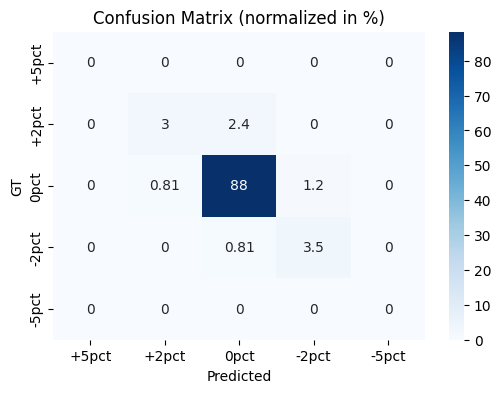

In [84]:
val_time_idx = data.query("split == 'val'")['time_idx'].values
i = 0
pred_value = preds.output[:, i].cpu().numpy()
pred_idx = preds.x['decoder_time_idx'][:, i].cpu().numpy()


data['pred'] = 0.0
data.loc[pred_idx, 'pred'] = pred_value

df_val = data.query("split == 'val'").copy()
df_val['pred_cat'] = df_val['pred'].apply(categorize_target)
df_val = df_val[['ts', 'target', 'target_ret', 'pred', 'pred_cat']]
df_val.to_csv('results/tft_val.csv')


print('Validation results')
plot_cm(df_val['pred_cat'], df_val['target'])